In [103]:
import pandas as pd

In [104]:
df = pd.read_csv(('../data/feature_engineered.csv'))
df.set_index('Timestamp', inplace=True)

In [105]:
train_test_split = 0.2
train_size = int((1 - train_test_split) * len(df))
df_train = df.iloc[:train_size]
df_test  = df.iloc[train_size:]

In [106]:
print(df_train.shape)
print(df_test.shape)

(406, 23)
(102, 23)


In [107]:
tune_split = int(0.8 * len(df_train))
train_tune = df_train.iloc[:tune_split]
val_tune   = df_train.iloc[tune_split:]


In [108]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit

In [109]:
df.columns


Index(['Unnamed: 0', 'Voltage (V)', 'Current (A)', 'Power Consumption (kW)',
       'Reactive Power (kVAR)', 'Power Factor', 'Solar Power (kW)',
       'Wind Power (kW)', 'Grid Supply (kW)', 'Voltage Fluctuation (%)',
       'Temperature (°C)', 'Humidity (%)', 'Electricity Price (USD/kWh)',
       'Predicted Load (kW)', 'load_da', 'load_d2', 'lag_1', 'lag_2', 'lag_3',
       'pct_tmp_chg', 'pow_cons_chg', 'roll_mean_load3', 'roll_std_load3'],
      dtype='object')

In [ ]:
X_train_tune = train_tune.drop(['Power Consumption (kW)', 'load_da', 'load_d2'], axis=1)
y_train_tune = train_tune['load_da']

X_val_tune = val_tune.drop(['Power Consumption (kW)', 'load_da', 'load_d2'], axis=1)
y_val_tune = val_tune['load_da']


In [111]:
rf = RandomForestRegressor(random_state=42, n_jobs=-1, oob_score=True)

param_space = {
    'n_estimators': Integer(250, 600),
    'max_depth': Integer(3, 8),
    'min_samples_split': Integer(4, 12),
    'min_samples_leaf': Integer(12, 16),
    'max_features': Real(0.2, 0.6),
    'bootstrap': [True],
}

tscv = TimeSeriesSplit(n_splits=6)

opt = BayesSearchCV(
    estimator=rf,
    search_spaces=param_space,
    n_iter=30,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    verbose=0
)

opt.fit(X_train_tune, y_train_tune)
print("Best Parameters:", opt.best_params_)
print("Best CV Score:", -opt.best_score_)


/Users/pranavsrinivasvenkatesh/anaconda3/envs/streamlitenv/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters: OrderedDict([('bootstrap', True), ('max_depth', 3), ('max_features', 0.203672359239111), ('min_samples_leaf', 14), ('min_samples_split', 9), ('n_estimators', 482)])
Best CV Score: 0.30699414969670175


/Users/pranavsrinivasvenkatesh/anaconda3/envs/streamlitenv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pranavsrinivasvenkatesh/anaconda3/envs/streamlitenv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


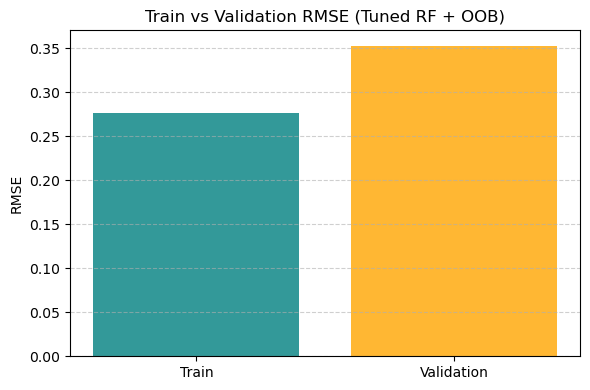

In [112]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
best_rf = opt.best_estimator_

train_pred = best_rf.predict(X_train_tune)
val_pred   = best_rf.predict(X_val_tune)

train_rmse = mean_squared_error(y_train_tune, train_pred, squared=False)
val_rmse   = mean_squared_error(y_val_tune, val_pred, squared=False)

plt.figure(figsize=(6, 4))
plt.bar(['Train', 'Validation'], [train_rmse, val_rmse],
        color=['teal', 'orange'], alpha=0.8)
plt.title('Train vs Validation RMSE (Tuned RF + OOB)')
plt.ylabel('RMSE')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [113]:
X_test_tune = df_test.drop(['Power Consumption (kW)', 'load_da', 'load_d2'], axis=1)
y_test_tune = df_test['load_da']

test_pred = best_rf.predict(X_test_tune)

test_rmse = mean_squared_error(y_test_tune, test_pred, squared=False)


/Users/pranavsrinivasvenkatesh/anaconda3/envs/streamlitenv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [114]:
from sklearn.metrics import mean_absolute_error
train_mae = mean_absolute_error(y_train_tune, train_pred)
test_mae = mean_absolute_error(y_test_tune, test_pred)
val_mae = mean_absolute_error(y_val_tune, val_pred)
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Validation RMSE: {val_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

Train RMSE: 0.2764
Validation RMSE: 0.3527
Test RMSE: 0.3037


Train RMSE: 0.2561
Validation RMSE: 0.3536
Test RMSE: 0.3079


In [ ]:
X_train_tune = train_tune.drop(['Power Consumption (kW)', 'load_da', 'load_d2'], axis=1)
y_train_tune = train_tune['load_d2']

X_val_tune = val_tune.drop(['Power Consumption (kW)', 'load_da', 'load_d2'], axis=1)
y_val_tune = val_tune['load_d2']

In [ ]:
rf = RandomForestRegressor(random_state=42, n_jobs=-1, oob_score=True)

param_space = {
    'n_estimators': Integer(250, 600),
    'max_depth': Integer(3, 8),
    'min_samples_split': Integer(4, 12),
    'min_samples_leaf': Integer(12, 16),
    'max_features': Real(0.2, 0.6),
    'bootstrap': [True],
}

tscv = TimeSeriesSplit(n_splits=6)

opt = BayesSearchCV(
    estimator=rf,
    search_spaces=param_space,
    n_iter=30,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    verbose=0
)

opt.fit(X_train_tune, y_train_tune)
print("Best Parameters:", opt.best_params_)
print("Best CV Score:", -opt.best_score_)




/Users/pranavsrinivasvenkatesh/anaconda3/envs/streamlitenv/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters: OrderedDict([('bootstrap', True), ('max_depth', 3), ('max_features', 0.24031309098065493), ('min_samples_leaf', 14), ('min_samples_split', 11), ('n_estimators', 478)])
Best CV Score: 0.30700327626909035


/Users/pranavsrinivasvenkatesh/anaconda3/envs/streamlitenv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [117]:
X_test_tune = df_test.drop(['Power Consumption (kW)', 'load_da', 'load_d2'], axis=1)
y_test_tune = df_test['load_d2']

test_pred = best_rf.predict(X_test_tune)

test_rmse = mean_squared_error(y_test_tune, test_pred, squared=False)

train_mae = mean_absolute_error(y_train_tune, train_pred)
test_mae = mean_absolute_error(y_test_tune, test_pred)
val_mae = mean_absolute_error(y_val_tune, val_pred)
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Validation RMSE: {val_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

Train RMSE: 0.2764
Validation RMSE: 0.3527
Test RMSE: 0.2821


/Users/pranavsrinivasvenkatesh/anaconda3/envs/streamlitenv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
